In [3]:
from collections import Counter

import pandas as pd

In [5]:
import matplotlib.pyplot as plt

from tqdm import tqdm # progress apply :)
tqdm.pandas()

from datetime import datetime
today=datetime.today().strftime('%Y-%m-%d')

%load_ext autoreload
%autoreload 2
def d(l):
    pd.set_option('display.max_colwidth', l)

In [27]:
#!pip install keybert

In [7]:
new_articles=pd.read_excel("2025-04-26 Manual Annotation results_Inclusion.xlsx")[["ID","text"]]
with open('2025-06-06_final_data.txt') as txt:
    dataID=txt.read().split(",")


df=pd.read_json("2025-06-06 PDF import filtered.json")

# check if all data is importet
df=df[df.index.isin(dataID)]
t=df.index.to_list()
set(dataID)-set(t)
print(df.shape, len(dataID))


(1018, 6) 1018


In [15]:
import pandas as pd
import spacy

#!python -m spacy download en_core_web_trf
#import spacy_transformers
#from spacytextblob.spacytextblob import SpacyTextBlob
from tqdm import tqdm  # For progress bar
#import torch
#print(torch.version.cuda)
#print(torch.__version__)
#print(torch.cuda.is_available())

nlp = spacy.load("en_core_web_trf")  # Disable unnecessary components

# Add the SpacyTextBlob component for sentiment analysis
#from spacytextblob import spacytextblob
#nlp.add_pipe("spacytextblob")
#sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest",  device=0)  # Use GPU

spacy.require_gpu()

True

In [25]:
# Define keyword lists
import regex as re

mistake_keys = ["honest", "mistake", "accident", "computational", "withdraw", "withdrew", "correct", "error"]
misconduct_keys = ["fraud", "misconduct", "plagia", "scandal", "guilt", "fabricat"]

qqps_keys = ["tortured phrases", "p-hacking", "cherry picking", "hacking", "fake", "questionable", "fabricat", "manipula", "fudge", "scam"]
# refined after manual annotation of 20 samples.

misconduct_keys = misconduct_keys + qqps_keys
all_keys = mistake_keys + misconduct_keys

# Compile regex patterns


words_mistake="(" + "|".join(mistake_keys) + ")" +r"{i<=2:\s}(?b)(?e)"
words_misconduct="(" + "|".join(misconduct_keys) + ")" +r"{i<=2:\s}(?b)(?e)"
words_retract = re.compile("retract{e<=2}", re.IGNORECASE)


# Constants for regex patterns
WORDS_MISCONDUCT = re.compile("(" + "|".join(misconduct_keys) + ")" +r"{i<=2:\s}(?b)(?e)")
WORDS_MISTAKE = re.compile("(" + "|".join(mistake_keys) + ")" +r"{i<=2:\s}(?b)(?e)")
WORDS_RETRACT = re.compile("retract{e<=2}", re.IGNORECASE)

In [17]:
# Function to process texts
def process_texts(texts):
    """
    Process a list of texts using spaCy and extract relevant information.
    """
    # Process the texts through the spaCy pipeline in batches
    docs = list(nlp.pipe(texts, batch_size=32))  # Batch processing for efficiency

    results = []
    for doc in docs:
        # Keyword matching using regex
        misconduct_matches = re.findall(words_misconduct, doc.text.lower())
        mistake_matches = re.findall(words_mistake, doc.text.lower())
        retract_matches = re.findall(words_retract, doc.text.lower())

        # Collect results for each document
        results.append({
            "Lemmata": [token.lemma_ for token in doc],  # Lemmatized text
            "NoStopwords": [token.text for token in doc if not token.is_stop and token.is_alpha],  # Text without stopwords
            "Nouns_Verbs" : [token.lemma_ for token in doc if ((token.pos_ == "NOUN") or (token.pos_ == "VERB")) and (len(token.lemma_)>2)],
          #  "Sentiment_Polarity": doc._.blob.polarity,  # Sentiment polarity from SpacyTextBlob
         #   "Sentiment_Subjectivity": doc._.blob.subjectivity,  # Sentiment subjectivity from SpacyTextBlob
            "ner_orga": [ent.text for ent in doc.ents if (ent.label_ == "ORG")],
            "ner_person": [ent.text for ent in doc.ents if (ent.label_ == "PERSON")],

            "misconduct": misconduct_matches,  # List of misconduct-related matches
            "mistake": mistake_matches,  # List of mistake-related matches
            "retract": retract_matches,  # List of retract-related matches
            "n_misconduct": len(misconduct_matches),  # Count of misconduct matches
            "n_mistake": len(mistake_matches),  # Count of mistake matches
            "n_retract": len(retract_matches)  # Count of retract matches
        })

    # Return a DataFrame with results
    return pd.DataFrame(results)
results=progress_apply(process_texts(df.text))

In [27]:
# improved function. But the other works as well.

import re
import pandas as pd
from tqdm import tqdm



def process_texts(texts, batch_size=32, misconduct_pattern=WORDS_MISCONDUCT, mistake_pattern=WORDS_MISTAKE, retract_pattern=WORDS_RETRACT):
    """
    Process a list of texts using spaCy and extract relevant information.
    """
    # Filter out invalid inputs
    texts = [text for text in texts if isinstance(text, str) and text.strip()]


    # Process texts in batches with a progress bar
    docs = list(tqdm(nlp.pipe(texts, batch_size=batch_size), total=len(texts), desc="Processing texts"))

    results = []
    for doc in docs:
        lower_text = doc.text.lower()

        # Regex matching
        misconduct_matches = misconduct_pattern.findall(lower_text)
        mistake_matches = mistake_pattern.findall(lower_text)
        retract_matches = retract_pattern.findall(lower_text)

        # Collect results for each document
        results.append({
            "Lemmata": [token.lemma_ for token in doc],
            "NoStopwords": [token.text for token in doc if not token.is_stop and token.is_alpha],
            "Nouns_Verbs": [token.lemma_ for token in doc if token.pos_ in {"NOUN", "VERB"} and len(token.lemma_) > 2],
            "ner_orga": [ent.text for ent in doc.ents if ent.label_ == "ORG"],
            "ner_person": [ent.text for ent in doc.ents if ent.label_ == "PERSON"],
            "misconduct": misconduct_matches,
            "mistake": mistake_matches,
            "retract": retract_matches,
            "n_misconduct": len(misconduct_matches),
            "n_mistake": len(mistake_matches),
            "n_retract": len(retract_matches),
        })

    return pd.DataFrame(results)

results2 = process_texts(df.text[:10], batch_size=32)

Processing texts: 100%|█████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


In [32]:
results.head(2)

,Lemmata,NoStopwords,Nouns_Verbs,ner_orga,ner_person,misconduct,mistake,retract,n_misconduct,n_mistake,n_retract
0,"[25.7, %, have, die, after, 28, day, ,, compar...","[died, days, compared, received, standard, car...","[die, day, compare, with23.5%inagroupof3132pat...","[the University of Tübingen, theWorld Health O...","[Kremsner, Landray, Donald Trump, Mitja, White...","[misconduct, fraud]",[],"[retract, retract, retract, retract, retract, ...",2,0,8
1,"[scientist, will, also, be, scour, the, genomi...","[Scientists, scouring, genomic, diversity, sig...","[scientist, scour, diversity, sign, virus, get...","[Peking University, the University of Glasgow,...","[Lu, Drosten]",[],[],[retract],0,0,1


In [34]:
from transformers import pipeline

# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", truncation=True)

# Apply the model to the 'text' column with truncation to handle long inputs
df["sentiment"] = df["text"].apply(lambda x: sentiment_pipeline(x[:512])[0]["label"])
df["sentiment"].value_counts()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


sentiment
neutral     668
negative    314
positive     36
Name: count, dtype: int64

In [35]:
sentiment=df["sentiment"].value_counts()
sentiment/sentiment.sum()

sentiment
neutral     0.656189
negative    0.308448
positive    0.035363
Name: count, dtype: float64

In [36]:
#!pip install keybert
from keybert import KeyBERT
kw_model = KeyBERT()

df["keywords_likely"]=df.text.progress_apply(lambda x: kw_model.extract_keywords(x, keyphrase_ngram_range=(1, 1), stop_words='english',top_n=5))

100%|███████████████████████████████████████| 1018/1018 [02:42<00:00,  6.27it/s]


In [37]:
df["keywords_only"]=df["keywords_likely"].apply(lambda x: [i[0].rstrip("s") for i in x])

<Axes: title={'center': 'top 10 keywords'}, ylabel='keywords_only'>

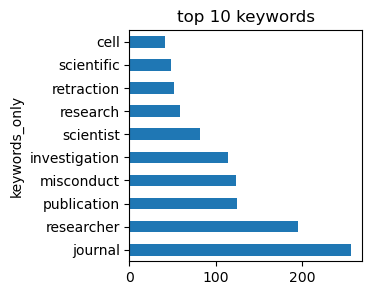

In [38]:
top10_keywords=df["keywords_only"].explode().value_counts()[:10]
top10_keywords.plot.barh(figsize=(3,3),title="top 10 keywords")

In [39]:
df["keywords_filtered"]=df["keywords_only"].apply(lambda x: [i for i in x if i not in top10_keywords.keys()])
df["keywords_filtered"].explode().value_counts()[:10]

keywords_filtered
vaccine       35
retracted     35
finding       33
reviewer      28
studie        28
fraudulent    27
fraud         27
stem          26
author        25
science       24
Name: count, dtype: int64

In [40]:
results.index=df.index
df=pd.concat([df, results], axis=1)

In [41]:
df["misconduct"]

Science113                                  [misconduct, fraud]
Science116                                                   []
Science119                                                   []
Science149                                              [fraud]
Science159                                [fraud, fraud, fraud]
                                    ...                        
Nature1223                                                   []
Nature1358                                                   []
Nature293     [plagia, fraud, fake, misconduct, misconduct, ...
Nature507b                                        [fraud, fake]
Nature454b                                        [fraud, fake]
Name: misconduct, Length: 1018, dtype: object

<Axes: ylabel='misconduct'>

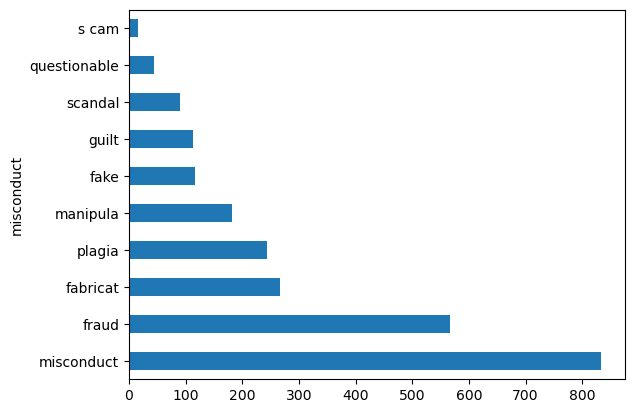

In [42]:
df.misconduct.explode().explode().dropna().value_counts()[:10].plot.barh()


In [43]:
# Define a function to compare the integer values
def compare_lists(row):
    if row["n_mistake"] > row["n_misconduct"]:
        return "mistake"
    elif row["n_mistake"] < row["n_misconduct"]:
        return "misconduct"
    else:
        return "none"

# Apply the function to each row
df["dict_topic"] = df.apply(compare_lists, axis=1)


<Axes: title={'center': 'Document Level: Framing Type (dict)'}, ylabel='count'>

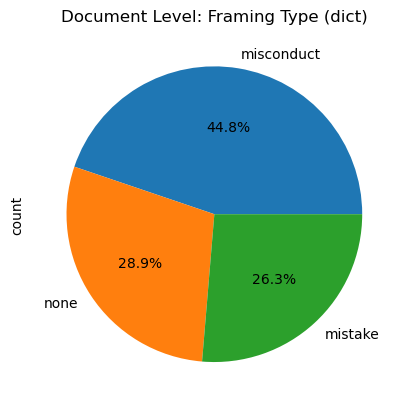

In [44]:
df.dict_topic.value_counts().plot.pie(title="Document Level: Framing Type (dict)", autopct='%1.1f%%')

In [45]:
df["NoStopwords"][0]

['died',
 'days',
 'compared',
 'received',
 'standard',
 'care',
 'data',
 'convincingly',
 'rule',
 'meaningful',
 'mortality',
 'investigators',
 'ended',
 'study',
 'early',
 'promised',
 'publish',
 'results',
 'assoon',
 'aspossible',
 'Editors',
 'co',
 'authors',
 'missed',
 'warning',
 'signs',
 'critics',
 'Theresults',
 'arepersuading',
 'somedoctors',
 'stop',
 'drug',
 'hydroxychloroquine',
 'despite',
 'thin',
 'evidence',
 'promise',
 'says',
 'better',
 'shifting',
 'attention',
 'drugs',
 'actually',
 'work',
 'Kremsner',
 'University',
 'Tübingen',
 'agrees',
 'awonderdrug',
 'question',
 'proceed',
 'hydroxychloroquine',
 'trials',
 'new',
 'findings',
 'raise',
 'questions',
 'stop',
 'trials',
 'smallerthanRecovery',
 'thuslesspowerful',
 'outcomes',
 'unlikely',
 'change',
 'minds',
 'continuing',
 'trials',
 'prevent',
 'researchers',
 'testing',
 'drugs',
 'better',
 'chance',
 'working',
 'robs',
 'patients',
 'chance',
 'try',
 'Landray',
 'says',
 'theWorld',

In [46]:
df["name"]=df.index

In [47]:
df.to_csv("2025-06-07 data with dict_approach.csv")
df.to_json("2025-06-07 data with dict_approach.json")